In [64]:
# Directory 
import os
os.chdir("/home/jovyan/work/GP/")
print(os.getcwd())

/home/jovyan/work/GP


In [65]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import scipy.stats as stats
from calendar import monthrange
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

In [66]:
# Read & Check data
Accident_London_cyc = pd.read_csv("df_per_coll_London_cyc_s1.csv")
print(
    f"There are {Accident_London_cyc.shape[0]} rows and {Accident_London_cyc.shape[1]} columns."
)#df size
print(Accident_London_cyc["police_force"].value_counts()) # London [1,48]
print(Accident_London_cyc["casualty_type"].value_counts()) # cycling
print(Accident_London_cyc.columns) # mixed types of variables in 'accident_index_x' and 'accident_reference_x'

There are 24594 rows and 23 columns.
police_force
1     24193
48      401
Name: count, dtype: int64
casualty_type
1    24594
Name: count, dtype: int64
Index(['accident_index', 'accident_year_x', 'accident_reference_x',
       'longitude', 'latitude', 'police_force', 'accident_severity', 'date',
       'day_of_week', 'local_authority_district', 'road_type', 'speed_limit',
       'light_conditions', 'weather_conditions', 'road_surface_conditions',
       'lsoa_of_accident_location', 'casualty_class', 'sex_of_casualty',
       'casualty_severity', 'pedestrian_location', 'casualty_type',
       'casualty_distance_banding', 'time'],
      dtype='object')


In [67]:
''' # To check the font I had
from matplotlib import font_manager

# List out all the font
for font in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    print(font)

# Check the names of fonts
font_names = [font_manager.FontProperties(fname=fname).get_name() for fname in font_manager.findSystemFonts()]
print(set(font_names)) 
'''

" # To check the font I had\nfrom matplotlib import font_manager\n\n# List out all the font\nfor font in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):\n    print(font)\n\n# Check the names of fonts\nfont_names = [font_manager.FontProperties(fname=fname).get_name() for fname in font_manager.findSystemFonts()]\nprint(set(font_names)) \n"

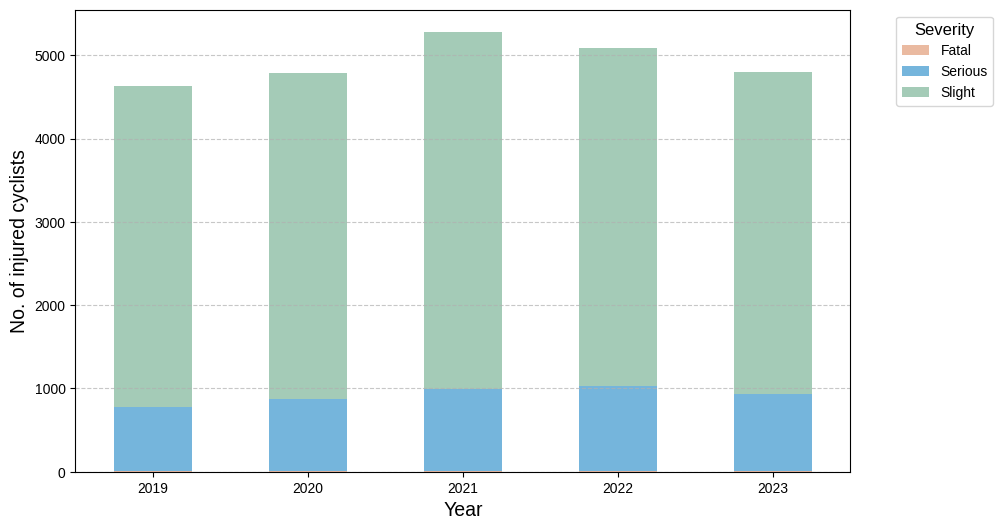

In [68]:
# Part 1: Make a bar graph (total count)
# Colors
colors = ['#eabaa1', '#75b5dc', '#a4cbb7']

# 1. Total count (by year & by level of severity)
severity_distribution = (
    Accident_London_cyc.groupby(["accident_year_x", "casualty_severity"])
    .size()
    .reset_index(name="count")
)

# 2. Create pivot table
pivot_table = severity_distribution.pivot(
    index="accident_year_x", columns="casualty_severity", values="count"
).fillna(0)

# Define [1, 2, 3] -means Fatal, Serious, Slight
pivot_table = pivot_table[[1, 2, 3]] if all(col in pivot_table.columns for col in [1, 2, 3]) else pivot_table

# 3. Make the bar graph
ax = pivot_table.plot(
    kind="bar", 
    stacked=True, 
    figsize=(10, 6), 
    color=colors,
    width=0.5
)
ax.set_xlim(-0.5, len(pivot_table.index) - 0.5)

# Add plot elements
plt.rc('font', family='Liberation Sans') 
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('No. of injured cyclists', fontsize=14)
ax.tick_params(axis='x', rotation=0, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Adjust legend 
severity_labels = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, 
    [severity_labels[int(label)] for label in labels],  
    title='Severity',
    fontsize=10,
    title_fontsize=12,
    bbox_to_anchor=(1.05, 1),  # put the legend on right side 
    loc='upper left'
)

# Show the grid line
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the figure
plt.show()

In [69]:
print(severity_distribution)

    accident_year_x  casualty_severity  count
0              2019                  1      5
1              2019                  2    773
2              2019                  3   3852
3              2020                  1      6
4              2020                  2    864
5              2020                  3   3921
6              2021                  1     10
7              2021                  2    989
8              2021                  3   4284
9              2022                  1      7
10             2022                  2   1021
11             2022                  3   4065
12             2023                  1      8
13             2023                  2    931
14             2023                  3   3858


In [70]:
# Part 2: Make a line graph (accident rate)
# 2.1. Calculate yearly accident rate 
# 2.1.1. Total trips data (in Million Trips per Day)
## Source: New TfL data shows sustained increases in walking and cycling in the capital - Transport for London
total_trips_day = {
    'Year': [2019, 2022, 2023],
    'Trips': [1.05, 1.19, 1.26]
}

total_trips_day = pd.DataFrame(total_trips_day)
print(total_trips_day)

   Year  Trips
0  2019   1.05
1  2022   1.19
2  2023   1.26


In [71]:
# 2.1.2. Yearly accident rate (per Million Trips)
severity_distribution = (
    Accident_London_cyc.groupby(["accident_year_x", "casualty_severity"])
    .size()
    .reset_index(name="count")
)

total_trips_day = {
    'Year': [2019, 2022, 2023],
    'Trips': [1.05, 1.19, 1.26]
}
total_trips_day = pd.DataFrame(total_trips_day)
severity_distribution = pd.DataFrame(severity_distribution)

# Define the number of days in each year
days_in_year = {2019: 365, 2020: 366, 2021: 365, 2022: 365, 2023: 365}

# Calculate the total trips per year (in millions)
total_trips_day['Total_Trips_Million'] = total_trips_day['Year'].map(
    lambda x: (total_trips_day.loc[total_trips_day['Year'] == x, 'Trips'].values[0] * days_in_year[x])
)

# Mark KSI accidents (Fatal + Serious)
severity_distribution['is_KSI'] = severity_distribution['casualty_severity'].isin([1, 2])

# Count the number of KSI accidents per year
KSI_per_year = severity_distribution[severity_distribution['is_KSI']].groupby('accident_year_x')['count'].sum().reset_index(name='KSI_Accidents')

# Count the number of slight accidents per year
slight_per_year = severity_distribution[severity_distribution['casualty_severity'] == 3].groupby('accident_year_x')['count'].sum().reset_index(name='Slight_Accidents')

# Merge the KSI and slight accident data
ksi_slight = pd.merge(KSI_per_year, slight_per_year, on='accident_year_x')

# Merge the total trips data
merged_df = pd.merge(ksi_slight, total_trips_day[['Year', 'Total_Trips_Million']], left_on='accident_year_x', right_on='Year')

# Calculate the accident rates per million trips
merged_df['KSI_Accident_Rate_Per_Million'] = (merged_df['KSI_Accidents'] / merged_df['Total_Trips_Million']) 
merged_df['Slight_Accident_Rate_Per_Million'] = (merged_df['Slight_Accidents'] / merged_df['Total_Trips_Million']) 

# Output the results
accident_rate_yr = merged_df[['accident_year_x', 'KSI_Accident_Rate_Per_Million', 'Slight_Accident_Rate_Per_Million']]
print(accident_rate_yr)

   accident_year_x  KSI_Accident_Rate_Per_Million  \
0             2019                       2.030007   
1             2022                       2.366755   
2             2023                       2.041748   

   Slight_Accident_Rate_Per_Million  
0                         10.050881  
1                          9.358812  
2                          8.388780  


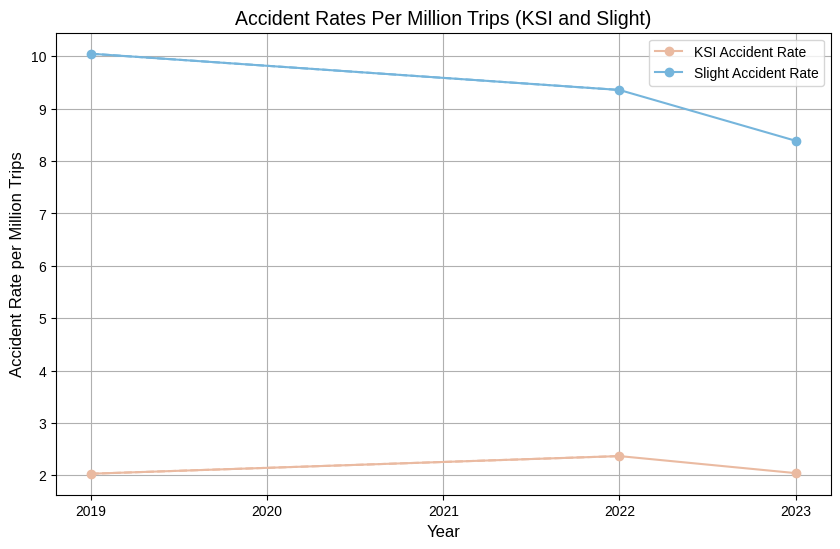

In [72]:
# Make a line graph (yearly accident rate)
plt.figure(figsize=(10, 6))

# Data
years = accident_rate_yr['accident_year_x'].tolist()
ksi_rates = accident_rate_yr['KSI_Accident_Rate_Per_Million'].tolist()
slight_rates = accident_rate_yr['Slight_Accident_Rate_Per_Million'].tolist()

# full years list
full_years = list(range(min(years), max(years) + 1))

# KSI Accident Rate
plt.plot(years, ksi_rates, marker='o', color='#eabaa1', 
         linestyle='-', 
         label='KSI Accident Rate')

# missing data: 2020-2021
plt.plot([2019, 2022], [ksi_rates[0], ksi_rates[1]], 
         color='#eabaa1', 
         linestyle='--')

# Slight Accident Rate
plt.plot(years, slight_rates, marker='o', color='#75b5dc', 
         linestyle='-', 
         label='Slight Accident Rate')

# missing data: 2020-2021
plt.plot([2019, 2022], [slight_rates[0], slight_rates[1]], 
         color='#75b5dc', 
         linestyle='--')

# Adding title and labels
plt.title('Accident Rates Per Million Trips (KSI and Slight)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Accident Rate per Million Trips', fontsize=12)

# X-axis
plt.xticks(full_years)

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [73]:
# 2.2. Calculate monthly accident rate (assumption: no change between months)
# 2.2.1. Total trips by month  
# Create a list to store the monthly trips for each year and month
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
year_month = []

# Create a list for the number of days in each month for each year
days_in_month = {
    2019: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],  # 2019, normal year
    2022: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],  # 2022, normal year
    2023: [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],  # 2023, normal year
}

# Adjust for leap years: 2020 was a leap year, February has 29 days.
days_in_month[2020] = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Calculate monthly trips for each year based on actual days per month
monthly_trips = []
for year, trips in zip(total_trips_day['Year'], total_trips_day['Trips']):
    # For each year, generate the Year_Month columns and calculate monthly trips
    for month, days in zip(months, days_in_month[year]):
        year_month.append(f"{year}_{month}")  # Generate Year_Month format
        monthly_trips.append(trips * days)  # Multiply daily trips by days in the month

# Create the new DataFrame 'trips_mon'
trips_mon = pd.DataFrame([monthly_trips], columns=year_month)

# Display the new DataFrame
print(trips_mon)

   2019_01  2019_02  2019_03  2019_04  2019_05  2019_06  2019_07  2019_08  \
0    32.55     29.4    32.55     31.5    32.55     31.5    32.55    32.55   

   2019_09  2019_10  ...  2023_03  2023_04  2023_05  2023_06  2023_07  \
0     31.5    32.55  ...    39.06     37.8    39.06     37.8    39.06   

   2023_08  2023_09  2023_10  2023_11  2023_12  
0    39.06     37.8    39.06     37.8    39.06  

[1 rows x 36 columns]


In [74]:
# 2.2.2 Calculate monthly accident rate
# Check date columns
random_rows = Accident_London_cyc.sample(n=5)
print(random_rows[['date']])
print(Accident_London_cyc['date'].dtype)
# transform to date format
Accident_London_cyc['date'] = pd.to_datetime(Accident_London_cyc['date'], errors='coerce')
# print type of variables
print(Accident_London_cyc['date'].dtype)

             date
22321  17/07/2023
11094  21/05/2021
18036  21/08/2022
5407   20/03/2020
5524   16/04/2020
object
datetime64[ns]


In [75]:
# Monthly （total number）
# Extract month 
Accident_London_cyc['month'] = Accident_London_cyc['date'].dt.to_period('M')

# Count total number of monthly accident 
monthly_counts = Accident_London_cyc.groupby('month').size()

# 2.2.2. Calculate monthly accident rate per million trips

# First, we need to calculate KSI accidents (Fatal + Serious) for each month
Accident_London_cyc['is_KSI'] = Accident_London_cyc['casualty_severity'].isin([1, 2])  # Mark KSI accidents

# Group by month and calculate the number of KSI accidents per month
monthly_KSI_counts = Accident_London_cyc[Accident_London_cyc['is_KSI']].groupby('month').size().reset_index(name='KSI_Accidents')

# Count the number of slight accidents (casualty_severity = 3)
monthly_slight_counts = Accident_London_cyc[Accident_London_cyc['casualty_severity'] == 3].groupby('month').size().reset_index(name='Slight_Accidents')

# Merge the KSI and slight accident data
monthly_accidents = pd.merge(monthly_KSI_counts, monthly_slight_counts, on='month', how='outer').fillna(0)

# Now, we need to get the corresponding monthly trips from the 'trips_mon' DataFrame
# Ensure that the 'year_month' format matches the 'month' period in 'Accident_London_cyc'
monthly_accidents['month'] = monthly_accidents['month'].astype(str)
monthly_accidents['year_month'] = monthly_accidents['month'].str.replace('-', '_')  # Convert to 'Year_Month' format

# Map trips data from trips_mon
monthly_accidents['Monthly_Trips'] = monthly_accidents['year_month'].map(lambda x: trips_mon[x].values[0] if x in trips_mon.columns else 0)

# Calculate accident rates per million trips
monthly_accidents['KSI_Accident_Rate_Per_Million'] = (monthly_accidents['KSI_Accidents'] / monthly_accidents['Monthly_Trips']) 
monthly_accidents['Slight_Accident_Rate_Per_Million'] = (monthly_accidents['Slight_Accidents'] / monthly_accidents['Monthly_Trips'])

# Display the result
print(monthly_accidents)

      month  KSI_Accidents  Slight_Accidents year_month  Monthly_Trips  \
0   2019-01             34               111    2019_01          32.55   
1   2019-02             21               134    2019_02          29.40   
2   2019-03             33               128    2019_03          32.55   
3   2019-04             30               150    2019_04          31.50   
4   2019-05             23               132    2019_05          32.55   
5   2019-06             21               111    2019_06          31.50   
6   2019-07             20               124    2019_07          32.55   
7   2019-08             31               114    2019_08          32.55   
8   2019-09             23               119    2019_09          31.50   
9   2019-10             32               123    2019_10          32.55   
10  2019-11             23               133    2019_11          31.50   
11  2019-12             22               117    2019_12          32.55   
12  2020-01             22            

In [76]:
# 另一种替代方案 ？？？
# 创建完整的月份范围
all_months = pd.date_range(start=monthly_accidents['month'].min(), 
                            end=monthly_accidents['month'].max(), 
                            freq='MS')

# 创建一个新的DataFrame，包含所有月份
full_monthly_df = pd.DataFrame({'month': all_months})

# 使用concat合并
monthly_accidents_filled = pd.concat([
    full_monthly_df, 
    monthly_accidents
], axis=1, join='outer')

# 去除重复列
monthly_accidents_filled = monthly_accidents_filled.loc[:,~monthly_accidents_filled.columns.duplicated()]

# 将2020-01到2021-12的数据填充为0
mask_2020_2021 = (monthly_accidents_filled['month'].dt.year.isin([2020, 2021]))
columns_to_fill = ['KSI_Accidents', 'Slight_Accidents', 
                   'KSI_Accident_Rate_Per_Million', 'Slight_Accident_Rate_Per_Million']

monthly_accidents_filled.loc[mask_2020_2021, columns_to_fill] = 0

# 转换月份为字符串格式
monthly_accidents_filled['month_str'] = monthly_accidents_filled['month'].dt.strftime('%Y-%m')
print(monthly_accidents_filled)

        month  KSI_Accidents  Slight_Accidents year_month  Monthly_Trips  \
0  2019-01-01             34               111    2019_01          32.55   
1  2019-02-01             21               134    2019_02          29.40   
2  2019-03-01             33               128    2019_03          32.55   
3  2019-04-01             30               150    2019_04          31.50   
4  2019-05-01             23               132    2019_05          32.55   
5  2019-06-01             21               111    2019_06          31.50   
6  2019-07-01             20               124    2019_07          32.55   
7  2019-08-01             31               114    2019_08          32.55   
8  2019-09-01             23               119    2019_09          31.50   
9  2019-10-01             32               123    2019_10          32.55   
10 2019-11-01             23               133    2019_11          31.50   
11 2019-12-01             22               117    2019_12          32.55   
12 2020-01-0

0    2019-01
1    2019-02
2    2019-03
3    2019-04
4    2019-05
Name: month_str, dtype: object


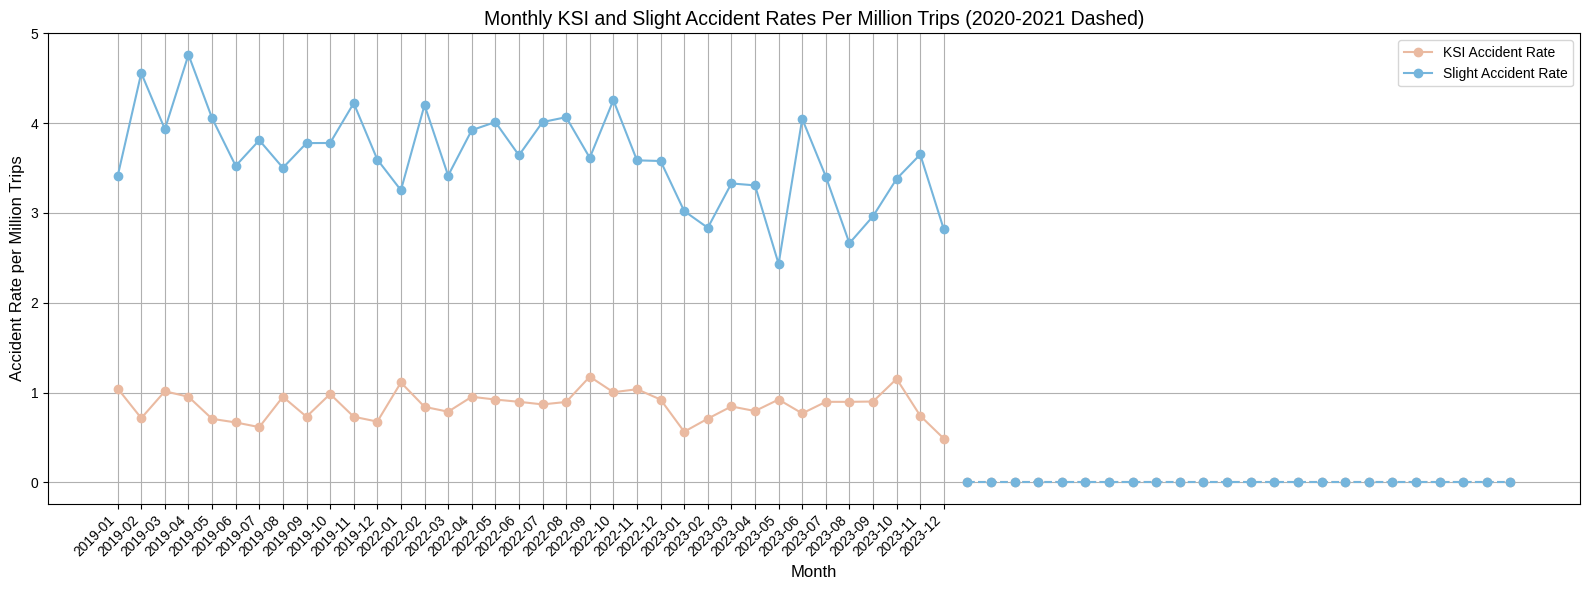

In [77]:
# Visualization ？？？
# Inspect 'month_str' to determine the correct format
print(monthly_accidents_filled['month_str'].head())  # Check the first few month_str values

# If the format is 'YYYY-MM', then we can parse it as such
monthly_accidents_filled['month_datetime'] = pd.to_datetime(monthly_accidents_filled['month_str'], format='%Y-%m', errors='coerce')

# If month_str includes day information, use the format '%Y-%m-%d' instead
# monthly_accidents_filled['month_datetime'] = pd.to_datetime(monthly_accidents_filled['month_str'], format='%Y-%m-%d', errors='coerce')

# Sort the data based on the 'month_datetime'
monthly_accidents_filled_sorted = monthly_accidents_filled.sort_values('month_datetime')

# Create a figure for the plot
plt.figure(figsize=(16, 6))

# Split the data into two parts: one for years without 2020-2021 and one for 2020-2021
df_normal = monthly_accidents_filled_sorted[~monthly_accidents_filled_sorted['month_str'].str.contains('2020|2021')]
df_dashed = monthly_accidents_filled_sorted[monthly_accidents_filled_sorted['month_str'].str.contains('2020|2021')]

# Plot normal years with solid lines
plt.plot(df_normal['month_str'], df_normal['KSI_Accident_Rate_Per_Million'], 
         color='#eabaa1', label='KSI Accident Rate', linestyle='-', marker='o')
plt.plot(df_normal['month_str'], df_normal['Slight_Accident_Rate_Per_Million'], 
         color='#75b5dc', label='Slight Accident Rate', linestyle='-', marker='o')

# Plot KSI and Slight accident rates with dashed lines for 2020-2021
plt.plot(df_dashed['month_str'], df_dashed['KSI_Accident_Rate_Per_Million'], 
         color='#eabaa1', linestyle='--', marker='o')
plt.plot(df_dashed['month_str'], df_dashed['Slight_Accident_Rate_Per_Million'], 
         color='#75b5dc', linestyle='--', marker='o')

# Adding title and labels
plt.title('Monthly KSI and Slight Accident Rates Per Million Trips (2020-2021 Dashed)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Accident Rate per Million Trips', fontsize=12)

# Rotate month labels for better visibility
plt.xticks(df_normal['month_str'], rotation=45, ha='right')

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


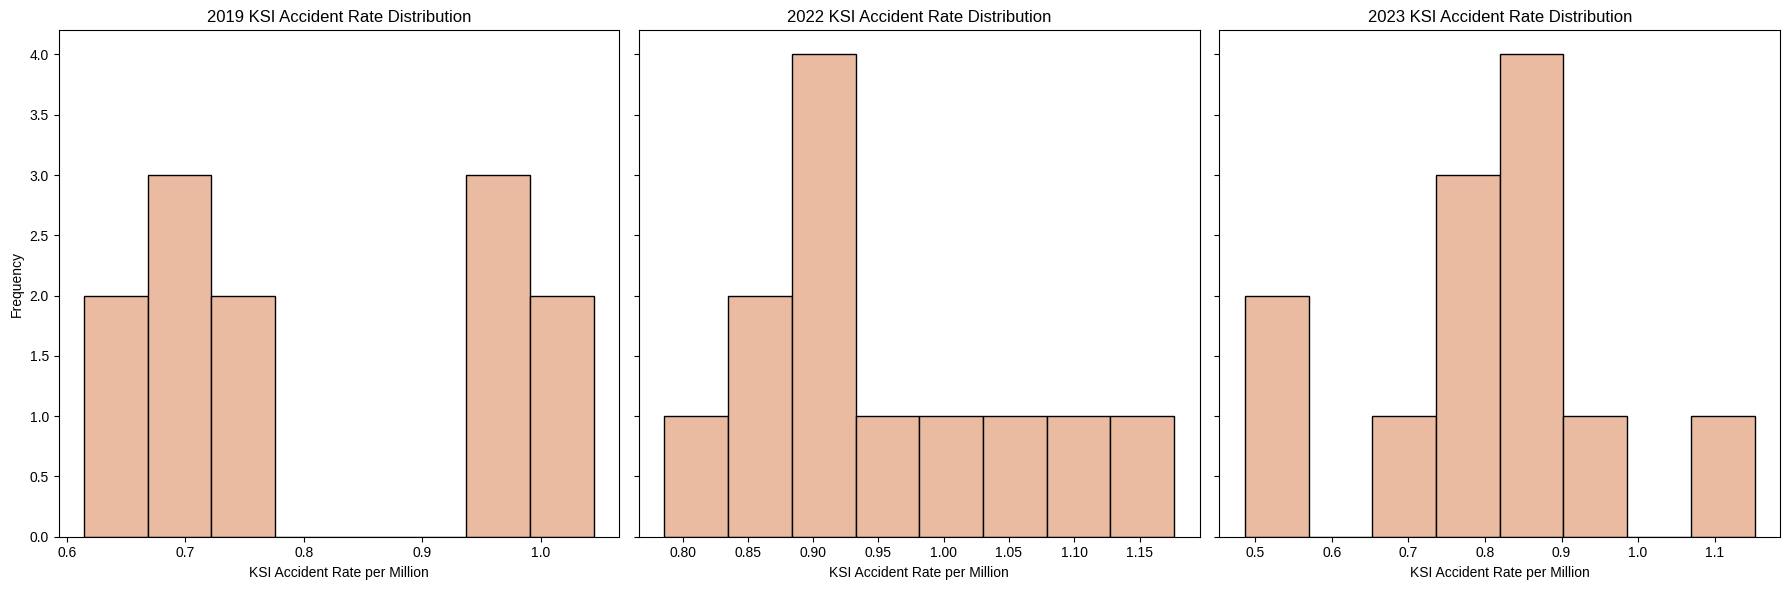

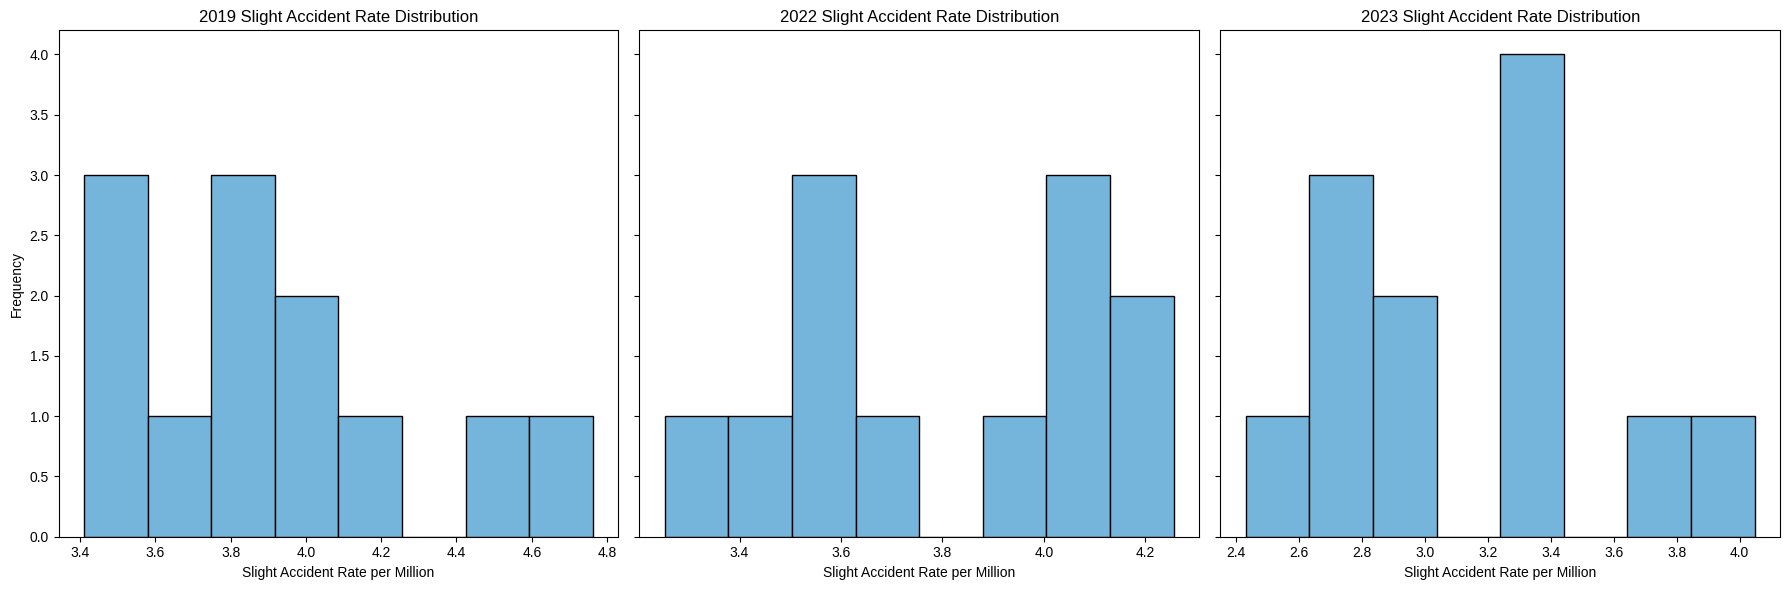

In [78]:
# Part 3: Significance difference? 
# 3.1. Check the distribution 
# Filter data for each year (2019, 2022, 2023)
accidents_2019 = monthly_accidents[monthly_accidents_filled['month_str'].str.contains('2019')]
accidents_2022 = monthly_accidents[monthly_accidents_filled['month_str'].str.contains('2022')]
accidents_2023 = monthly_accidents[monthly_accidents_filled['month_str'].str.contains('2023')]

# Create subplots to show three histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot histogram for 2019 KSI accident rates
axes[0].hist(accidents_2019['KSI_Accident_Rate_Per_Million'], bins=8, color='#eabaa1', edgecolor='black')
axes[0].set_title('2019 KSI Accident Rate Distribution')
axes[0].set_xlabel('KSI Accident Rate per Million')
axes[0].set_ylabel('Frequency')

# Plot histogram for 2022 KSI accident rates
axes[1].hist(accidents_2022['KSI_Accident_Rate_Per_Million'], bins=8, color='#eabaa1', edgecolor='black')
axes[1].set_title('2022 KSI Accident Rate Distribution')
axes[1].set_xlabel('KSI Accident Rate per Million')

# Plot histogram for 2023 KSI accident rates
axes[2].hist(accidents_2023['KSI_Accident_Rate_Per_Million'], bins=8, color='#eabaa1', edgecolor='black')
axes[2].set_title('2023 KSI Accident Rate Distribution')
axes[2].set_xlabel('KSI Accident Rate per Million')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Repeat the process for Slight Accident Rate distribution
# Create subplots for Slight Accident Rate distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot histogram for 2019 Slight accident rates
axes[0].hist(accidents_2019['Slight_Accident_Rate_Per_Million'], bins=8, color='#75b5dc', edgecolor='black')
axes[0].set_title('2019 Slight Accident Rate Distribution')
axes[0].set_xlabel('Slight Accident Rate per Million')
axes[0].set_ylabel('Frequency')

# Plot histogram for 2022 Slight accident rates
axes[1].hist(accidents_2022['Slight_Accident_Rate_Per_Million'], bins=8, color='#75b5dc', edgecolor='black')
axes[1].set_title('2022 Slight Accident Rate Distribution')
axes[1].set_xlabel('Slight Accident Rate per Million')

# Plot histogram for 2023 Slight accident rates
axes[2].hist(accidents_2023['Slight_Accident_Rate_Per_Million'], bins=8, color='#75b5dc', edgecolor='black')
axes[2].set_title('2023 Slight Accident Rate Distribution')
axes[2].set_xlabel('Slight Accident Rate per Million')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [79]:
# 3.2. Mann-Whitney U 2019 VS 2022
# 1. Select 2019 and 2022 data
data_2019 = monthly_accidents[monthly_accidents['year_month'].str.contains('2019')]
data_2022 = monthly_accidents[monthly_accidents['year_month'].str.contains('2022')]

# 2. Filter out KSI and Slight accident rate
ksi_2019 = data_2019['KSI_Accident_Rate_Per_Million']
ksi_2022 = data_2022['KSI_Accident_Rate_Per_Million']

slight_2019 = data_2019['Slight_Accident_Rate_Per_Million']
slight_2022 = data_2022['Slight_Accident_Rate_Per_Million']

# 3. Mann-Whitney U test
ksi_stat, ksi_p_value = mannwhitneyu(ksi_2019, ksi_2022, alternative='two-sided')
slight_stat, slight_p_value = mannwhitneyu(slight_2019, slight_2022, alternative='two-sided')

# 4. print results
print(f"KSI Accident Rate Comparison (2019 vs 2022):")
print(f"U-statistic: {ksi_stat}, P-value: {ksi_p_value}")

print(f"\nSlight Accident Rate Comparison (2019 vs 2022):")
print(f"U-statistic: {slight_stat}, P-value: {slight_p_value}")

# 5. is there significant difference
alpha = 0.05
if ksi_p_value < alpha:
    print("\nKSI Accident Rate shows significant difference between 2019 and 2022")
else:
    print("\nKSI Accident Rate does not show significant difference between 2019 and 2022")

if slight_p_value < alpha:
    print("Slight Accident Rate shows significant difference between 2019 and 2022")
else:
    print("Slight Accident Rate does not show significant difference between 2019 and 2022")


KSI Accident Rate Comparison (2019 vs 2022):
U-statistic: 41.0, P-value: 0.07812262869770041

Slight Accident Rate Comparison (2019 vs 2022):
U-statistic: 78.0, P-value: 0.7507794968518241

KSI Accident Rate does not show significant difference between 2019 and 2022
Slight Accident Rate does not show significant difference between 2019 and 2022


In [80]:
# 3.3. Mann-Whitney U 2019 VS 2023
# 1. Select 2019 and 2023 data
data_2019 = monthly_accidents[monthly_accidents['year_month'].str.contains('2019')]
data_2023 = monthly_accidents[monthly_accidents['year_month'].str.contains('2023')]

# 2. Filter out KSI and Slight accident rate
ksi_2019 = data_2019['KSI_Accident_Rate_Per_Million']
ksi_2023 = data_2023['KSI_Accident_Rate_Per_Million']

slight_2019 = data_2019['Slight_Accident_Rate_Per_Million']
slight_2023 = data_2023['Slight_Accident_Rate_Per_Million']

# 3. Mann-Whitney U test
ksi_stat, ksi_p_value = mannwhitneyu(ksi_2019, ksi_2023, alternative='two-sided')
slight_stat, slight_p_value = mannwhitneyu(slight_2019, slight_2023, alternative='two-sided')

# 4. print results
print(f"KSI Accident Rate Comparison (2019 vs 2023):")
print(f"U-statistic: {ksi_stat}, P-value: {ksi_p_value}")

print(f"\nSlight Accident Rate Comparison (2019 vs 2023):")
print(f"U-statistic: {slight_stat}, P-value: {slight_p_value}")

# 5. is there significant difference
alpha = 0.05
if ksi_p_value < alpha:
    print("\nKSI Accident Rate shows significant difference between 2019 and 2023")
else:
    print("\nKSI Accident Rate does not show significant difference between 2019 and 2023")

if slight_p_value < alpha:
    print("Slight Accident Rate shows significant difference between 2019 and 2023")
else:
    print("Slight Accident Rate does not show significant difference between 2019 and 2023")


KSI Accident Rate Comparison (2019 vs 2023):
U-statistic: 72.0, P-value: 1.0

Slight Accident Rate Comparison (2019 vs 2023):
U-statistic: 132.0, P-value: 0.0005920421458944265

KSI Accident Rate does not show significant difference between 2019 and 2023
Slight Accident Rate shows significant difference between 2019 and 2023


In [81]:
# 3.4. Mann-Whitney U 2022 VS 2023
# 1. Select 2019 and 2023 data
data_2022 = monthly_accidents[monthly_accidents['year_month'].str.contains('2022')]
data_2023 = monthly_accidents[monthly_accidents['year_month'].str.contains('2023')]

# 2. Filter out KSI and Slight accident rate
ksi_2022 = data_2022['KSI_Accident_Rate_Per_Million']
ksi_2023 = data_2023['KSI_Accident_Rate_Per_Million']

slight_2022 = data_2022['Slight_Accident_Rate_Per_Million']
slight_2023 = data_2023['Slight_Accident_Rate_Per_Million']

# 3. Mann-Whitney U test
ksi_stat, ksi_p_value = mannwhitneyu(ksi_2022, ksi_2023, alternative='two-sided')
slight_stat, slight_p_value = mannwhitneyu(slight_2022, slight_2023, alternative='two-sided')

# 4. print results
print(f"KSI Accident Rate Comparison (2022 vs 2023):")
print(f"U-statistic: {ksi_stat}, P-value: {ksi_p_value}")

print(f"\nSlight Accident Rate Comparison (2022 vs 2023):")
print(f"U-statistic: {slight_stat}, P-value: {slight_p_value}")

# 5. is there significant difference
alpha = 0.05
if ksi_p_value < alpha:
    print("\nKSI Accident Rate shows significant difference between 2022 and 2023")
else:
    print("\nKSI Accident Rate does not show significant difference between 2022 and 2023")

if slight_p_value < alpha:
    print("Slight Accident Rate shows significant difference between 2022 and 2023")
else:
    print("Slight Accident Rate does not show significant difference between 2022 and 2023")


KSI Accident Rate Comparison (2022 vs 2023):
U-statistic: 112.0, P-value: 0.02251735495187298

Slight Accident Rate Comparison (2022 vs 2023):
U-statistic: 125.0, P-value: 0.00243142047958196

KSI Accident Rate shows significant difference between 2022 and 2023
Slight Accident Rate shows significant difference between 2022 and 2023


In [82]:
# 3.5. Kruskal-Wallis H 2019 vs 2022 vs 2023
# 1. Select 2019, 2022 and 2023 data
data_2019 = monthly_accidents[monthly_accidents['year_month'].str.contains('2019')]
data_2022 = monthly_accidents[monthly_accidents['year_month'].str.contains('2022')]
data_2023 = monthly_accidents[monthly_accidents['year_month'].str.contains('2023')]

# 2. Filter out KSI and Slight accident rate
ksi_2019 = data_2019['KSI_Accident_Rate_Per_Million']
ksi_2022 = data_2022['KSI_Accident_Rate_Per_Million']
ksi_2023 = data_2023['KSI_Accident_Rate_Per_Million']

slight_2019 = data_2019['Slight_Accident_Rate_Per_Million']
slight_2022 = data_2022['Slight_Accident_Rate_Per_Million']
slight_2023 = data_2023['Slight_Accident_Rate_Per_Million']

# 3. Kruskal-Wallis H test
ksi_stat, ksi_p_value = kruskal(ksi_2019, ksi_2022, ksi_2023)
slight_stat, slight_p_value = kruskal(slight_2019, slight_2022, slight_2023)

# 4. print results
print(f"KSI Accident Rate Comparison (2019 vs 2022 vs 2023):")
print(f"H-statistic: {ksi_stat}, P-value: {ksi_p_value}")

print(f"\nSlight Accident Rate Comparison (2019 vs 2022 vs 2023):")
print(f"H-statistic: {slight_stat}, P-value: {slight_p_value}")

# 5. is there significant difference
alpha = 0.05
if ksi_p_value < alpha:
    print("\nKSI Accident Rate shows significant difference between 2019, 2022, and 2023")
else:
    print("\nKSI Accident Rate does not show significant difference between 2019, 2022, and 2023")

if slight_p_value < alpha:
    print("Slight Accident Rate shows significant difference between 2019, 2022, and 2023")
else:
    print("Slight Accident Rate does not show significant difference between 2019, 2022, and 2023")


KSI Accident Rate Comparison (2019 vs 2022 vs 2023):
H-statistic: 5.709411613235481, P-value: 0.057572756153539434

Slight Accident Rate Comparison (2019 vs 2022 vs 2023):
H-statistic: 14.516883339769162, P-value: 0.0007042045641876166

KSI Accident Rate does not show significant difference between 2019, 2022, and 2023
Slight Accident Rate shows significant difference between 2019, 2022, and 2023
